In [24]:
import os
import sys
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD as LSA
from ibopf.settings import settings
from ibopf.avocado_adapter import Dataset, MMMBOPFFeaturizer, AVOCADOFeaturizer
from ibopf import IBOPF, CompactIBOPF
import pacmap
from collections import defaultdict
import random
import time
plt.style.use("seaborn")
# we move to the main directory so the default settings load, you can always load new settings through a user_settings.json dictionary
base_path, curr_dir = os.path.split(os.getcwd())
if curr_dir == "notebooks":
    os.chdir(base_path)
os.getcwd()

'/media/francisco/data/irregular-bag-of-pattern'

# Space visualization
we use:
- UMAP
- UMAP + etiquetas
- PACMAP
- LSA

In [32]:
def load_features(dataset_name, method="IBOPF", tag="features_v3_LSA", sparse=False, selected_classes=None):
    # Load the dataset (metadata only)
    print("Loading dataset '%s'..." % dataset_name)
    dataset = Dataset.load(dataset_name, metadata_only=True)
    dataset.set_method(method)
    
    # Load the dataset features depending on method
    print("Loading features...")
    if method == "IBOPF":
        if sparse:
            dataset.load_sparse_features(tag)
        else:
            dataset.load_compact_features(tag)
        featurizer = MMMBOPFFeaturizer(include_metadata=True)
    else:
        dataset.load_raw_features()
        featurizer = AVOCADOFeaturizer()
        
    df_features = dataset.select_features(featurizer)
    metadata = dataset.metadata
    if selected_classes is not None:
        metadata = metadata[metadata["class"].isin(selected_classes)]
        df_features = df_features[df_features.index.isin(metadata.index)]
    labels = metadata["class"]      
    print(np.unique(labels))
    return df_features, labels

plot_labels_extra_short = {
    6: 'Single microlens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
} 

sn_classes = [42, 52, 53, 62, 64, 67, 90, 95]
var_classes = [16, 53, 92]
other_classes = [6, 15, 65, 88]

def prepare_labels(labels, idxs=None):
    try:
        labels = labels.to_numpy()
    except:
        pass
    if idxs is not None:
        labels = labels[idxs]
    labels_verbose =  [plot_labels_extra_short[x] for x in labels]
    print(np.unique(labels_verbose))
    le = LabelEncoder()
    le.fit(np.unique(labels_verbose))
    y = le.transform(labels_verbose)
    return y, le

def visualization2D(df, y, le, reducer="UMAP", ax=None, hide_labels=False):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 10), sharex = True)
    cax = ax.scatter(df[:, 0], df[:, 1], c=y, marker='.', s=1)
    if not hide_labels:
        ax.set_xlabel("%s 1" % reducer, fontsize=15)
        ax.set_ylabel("%s 2" % reducer, fontsize=15)
    # ax.legend();
    # cbar = plt.colorbar(cax, orientation='horizontal')
    # cbar.ax.set_xticks(np.array(range(y.max()+1)), 
                       # labels=[le.inverse_transform([i])[0] for i in (np.array(range(y.max()+1)))])
    # cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=90)
    # plt.show()
    return cax
    
def visualization3D(df, y, le, reducer="UMAP", ax=None, hide_labels=False):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 10), sharex = True)
    ax = plt.axes(projection='3d')
    cax = ax.scatter(df[:, 0], df[:, 1], df[:, 2],  c=y, marker='.')
    if not hide_labels:
        ax.set_xlabel("%s 1" % reducer)
        ax.set_ylabel("%s 2" % reducer)
        ax.set_zlabel("%s 3" % reducer)
    # ax.legend();
    # cbar = plt.colorbar(cax, orientation='horizontal')
    # cbar.ax.set_xticks(np.array(range(y.max()+1)), 
    #                    labels=[le.inverse_transform([i])[0] for i in (np.array(range(y.max()+1)))])
    # cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=90)
    # plt.show()
    return cax

def visualize_all(fea_methods, titles, labels, reducer, reducer_name, out_file, fit_with_labels=False, n_neighbors=None):
    scaler = StandardScaler()
    dfs_reduced = []
    reducer_o = None
    for df, title in zip(fea_methods, titles):
        if isinstance(reducer, str):
            if reducer.lower() == "umap":
                if n_neighbors is None:
                    n_neighbors = 15
                reducer_o = umap.UMAP(n_neighbors=n_neighbors)
            elif reducer.lower() == "lsa":
                reducer_o = LSA()
            elif reducer.lower() == "pacmap":
                reducer_o = pacmap.PaCMAP(n_neighbors=n_neighbors, MN_ratio=0.5, FP_ratio=4.0)
            else:
                raise ValueError("invalid reducer")
        else:
            reducer_o = reducer
            
        print("processing ", title)
        ini = time.time()
        if any(df.isna().any()):
            df = df.drop(columns=df.columns[df.isna().any()].tolist())
        
        scaler.fit(df)
        df_scaled = scaler.transform(df)
        
        if fit_with_labels:
            df_reduced = reducer_o.fit_transform(df_scaled, y=labels)
        else:
            df_reduced = reducer_o.fit_transform(df_scaled)
        dfs_reduced.append(df_reduced)
        print("-> DONE (TIME: %.3f)" % (time.time() - ini))
        try:
            reducer_o.del_pairs()
        except:
            pass
        del reducer_o
        reducer_o = None
        
    # plot
    print("PLOTING...")
    fig, ax = plt.subplots(1, len(dfs_reduced), figsize=(20, 10), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    y, le = prepare_labels(labels)
    hide_labels = False
    for i, df in enumerate(dfs_reduced):
        cax = visualization2D(df, y, le, reducer=reducer_name, ax=ax[i], hide_labels=hide_labels)
        if not hide_labels:
            hide_labels = True
        if i > 0:
            ax[i].set_xlabel("%s 1" % reducer_name, fontsize=15)
        else:
            ax[i].tick_params(axis="y", labelsize=14)

        ax[i].set_title(titles[i], fontsize=15)
        ax[i].tick_params(axis="x", labelsize=14)

    fig.suptitle("%s 2D visualization" % reducer_name, fontsize=15)

    cbar = plt.colorbar(cax, shrink=0.6, ax=ax.ravel().tolist(), orientation='horizontal')
    cbar.ax.set_xticks(np.array(range(y.max()+1)), 
                           labels=[le.inverse_transform([i])[0] for i in (np.array(range(y.max()+1)))])
    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=90, fontsize=14)
    plt.savefig(out_file)


def visualize_compare_repr(reducer=None, n_neighbors=None, reducer_name=None, fit_with_labels=False, selected_classes=None):
    avocado_fea, avocado_labels = load_features("plasticc_augment_v3", method="AVOCADO", selected_classes=selected_classes)
    ibopf_fea, ibopf_labels = load_features("plasticc_augment_v3", method="IBOPF", tag="features_v3_LSA", sparse=True, selected_classes=selected_classes)
    if isinstance(reducer, str):
        reducer_name = reducer
    visualize_all([ibopf_fea, avocado_fea], 
                  ["IBOPF", "AVOCADO"], 
                  avocado_labels, reducer, reducer_name, "notebooks/new_figures/compare_repr_%s.png" % reducer_name,
                 fit_with_labels=fit_with_labels, n_neighbors=n_neighbors)
    del ibopf_fea
    del avocado_fea
    

    
def visualize_compare_transform(repr_method="IBOPF", tag="features_v3_LSA", reducer_name="LSA"):
    df, labels1 = load_features("plasticc_augment_v3", method=repr_method, tag=tag, sparse=False)
    classes = np.unique(labels1)
    df2, labels2 = load_features("plasticc_test", method=repr_method, tag=tag, sparse=False)
    labels2 = labels2[labels2.index.isin(df2.index)]
    mask = [x in classes for x in labels2]

    titles = ["%d 2D TRAINING", "%d 2D TESTING"]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    labels = [labels1, labels2[mask]]
    
    count_labels_test = defaultdict(int)
    for l in labels[1].to_numpy():
        count_labels_test[l] += 1
    print("classes dist in test 10%")
    print(count_labels_test)
    
    threshold = 20000
    dfs2 = []
    for l_name, c in count_labels_test.items():
        df_lbl = labels[1]
        df_lbl = df_lbl[df_lbl == l_name]
        if c > threshold:
            idxs = random.sample(range(c), threshold)
            dfs2.append(df_lbl.iloc[idxs])
        else:
            dfs2.append(df_lbl)
            
    labels[1] = pd.concat(dfs2)
    df2_m = df2[df2.index.isin(labels[1].index)]
    
    count_labels_test2 = defaultdict(int)
    for l in labels[1].to_numpy():
        count_labels_test2[l] += 1
    print("classes dist in test 10%")
    print(count_labels_test2)
    
    dfs = [df.values, df2_m.values]
    hide_labels = False
    for i, df in enumerate(dfs):
        y, le = prepare_labels(labels[i])
        cax = visualization2D(df, y, le, reducer=reducer_name, ax=ax[i], hide_labels=hide_labels)
        if not hide_labels:
            hide_labels = True
        if i > 0:
            ax[i].set_xlabel("%s 1" % reducer_name, fontsize=15)
        else:
            ax[i].tick_params(axis="y", labelsize=14)

        ax[i].set_title(titles[i], fontsize=15)
        ax[i].tick_params(axis="x", labelsize=14)

    fig.suptitle("%s 2D visualization" % reducer_name, fontsize=15)

    cbar = plt.colorbar(cax, shrink=0.6, ax=ax.ravel().tolist(), orientation='horizontal')
    cbar.ax.set_xticks(np.array(range(y.max()+1)), 
                           labels=[le.inverse_transform([i])[0] for i in (np.array(range(y.max()+1)))])
    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=90, fontsize=14)
    del df
    del df2
    
# plt.savefig(out_file)

## VISUALIZE IBOPF VS AVOCADO

Loading dataset 'plasticc_augment_v3'...
Loading features...
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
processing  IBOPF
-> DONE (TIME: 159.632)
processing  AVOCADO
-> DONE (TIME: 97.333)
PLOTING...
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


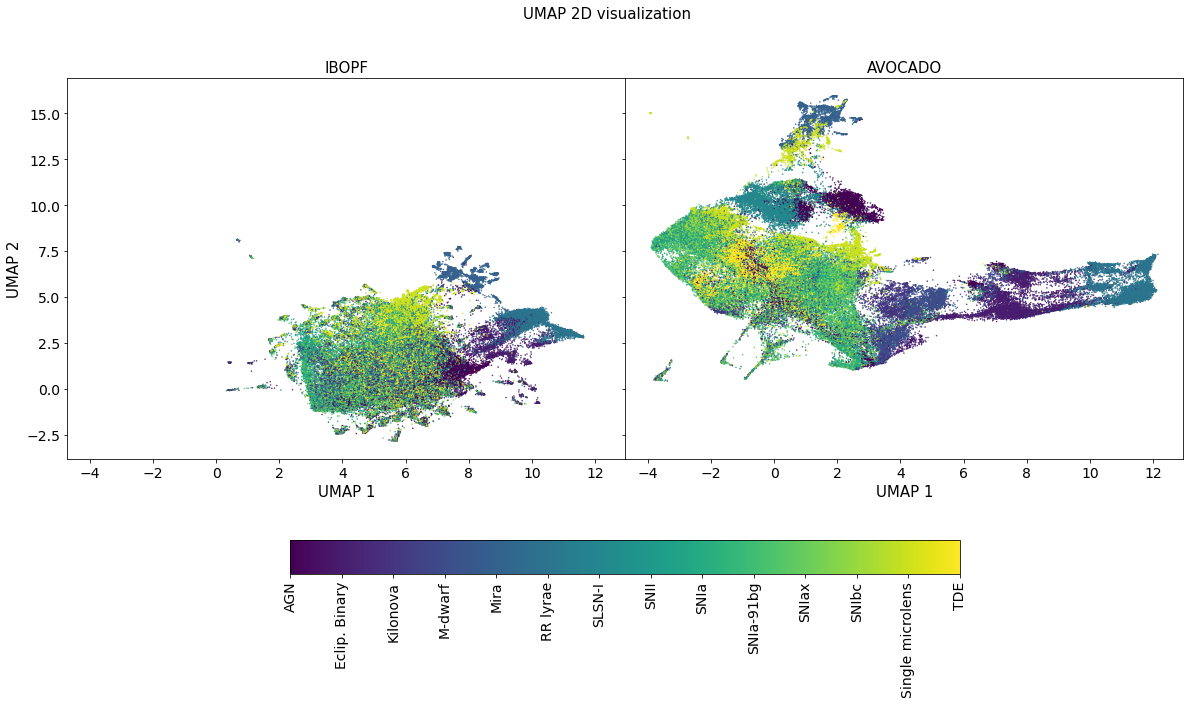

In [6]:
visualize_compare_repr(reducer="UMAP", n_neighbors=100, reducer_name=None, fit_with_labels=False)

Loading dataset 'plasticc_augment_v3'...
Loading features...
[42 52 53 62 64 67 90 95]
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
[42 52 53 62 64 67 90 95]
processing  IBOPF
-> DONE (TIME: 72.600)
processing  AVOCADO
-> DONE (TIME: 46.769)
PLOTING...
['Kilonova' 'Mira' 'SLSN-I' 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc']


/tmp/ipykernel_12098/4186328742.py:156: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(cax, shrink=0.6, ax=ax.ravel().tolist(), orientation='horizontal')


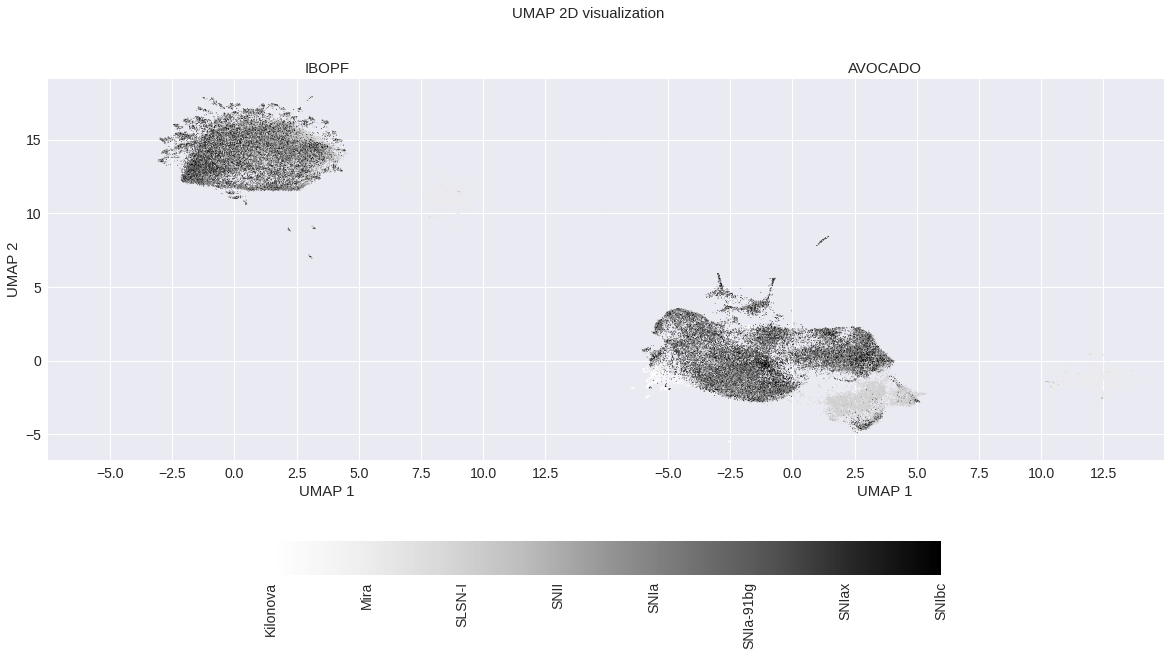

In [33]:
visualize_compare_repr(reducer="UMAP", n_neighbors=100, reducer_name=None, fit_with_labels=False, selected_classes=sn_classes)

Loading dataset 'plasticc_augment_v3'...
Loading features...
[16 53 92]
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
[16 53 92]
processing  IBOPF
-> DONE (TIME: 25.156)
processing  AVOCADO
-> DONE (TIME: 18.475)
PLOTING...
['Eclip. Binary' 'Mira' 'RR lyrae']


/tmp/ipykernel_12098/4186328742.py:156: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(cax, shrink=0.6, ax=ax.ravel().tolist(), orientation='horizontal')


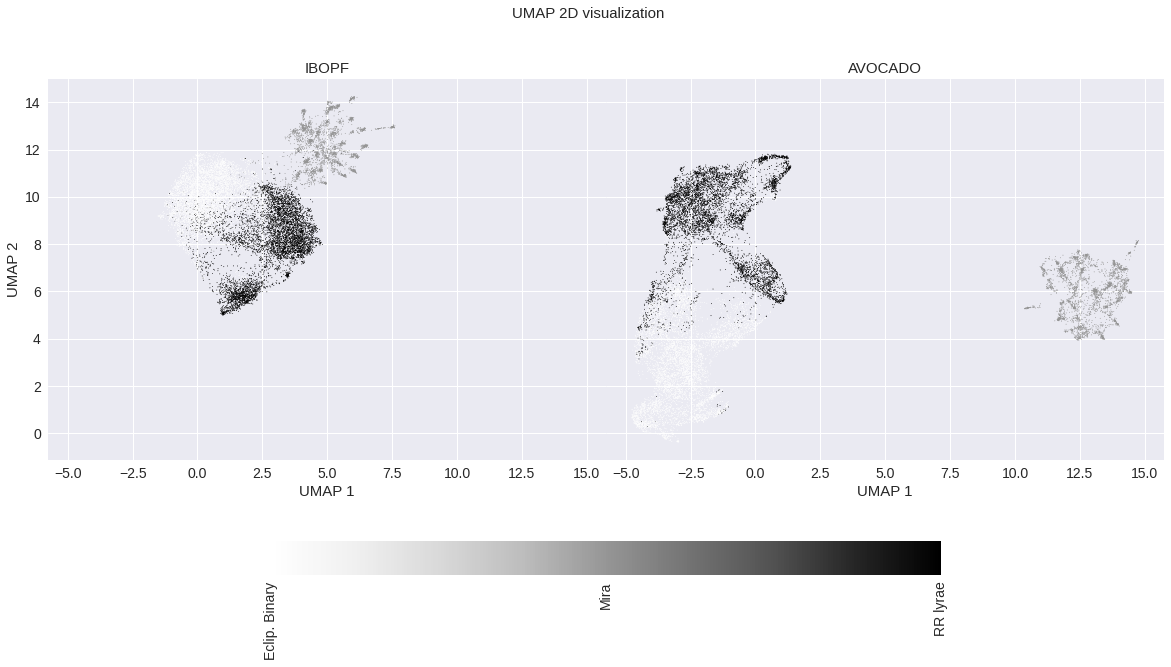

In [34]:
visualize_compare_repr(reducer="UMAP", n_neighbors=100, reducer_name=None, fit_with_labels=False, selected_classes=var_classes)

In [ ]:
visualize_compare_repr(reducer="UMAP", n_neighbors=100, reducer_name=None, fit_with_labels=False, selected_classes=other_classes)

Loading dataset 'plasticc_augment_v3'...
Loading features...
[ 6 15 65 88]
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
[ 6 15 65 88]
processing  IBOPF
-> DONE (TIME: 42.938)
processing  AVOCADO


Loading dataset 'plasticc_augment_v3'...
Loading features...
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
processing  IBOPF
-> DONE (TIME: 137.893)
processing  AVOCADO
-> DONE (TIME: 158.352)
PLOTING...
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


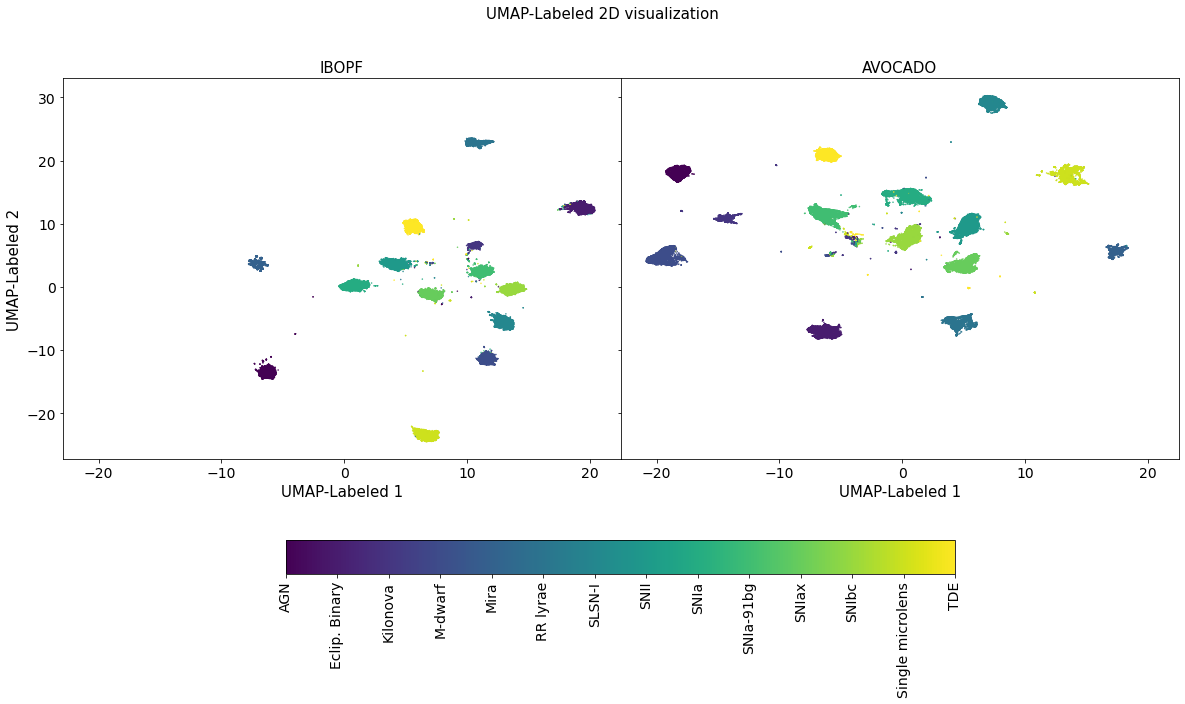

In [30]:
visualize_compare_repr(reducer=umap.UMAP(n_neighbors=100), n_neighbors=100, reducer_name="UMAP-Labeled", fit_with_labels=True)

Loading dataset 'plasticc_augment_v3'...
Loading features...
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
processing  IBOPF
-> DONE (TIME: 7.935)
processing  AVOCADO
-> DONE (TIME: 0.507)
PLOTING...
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


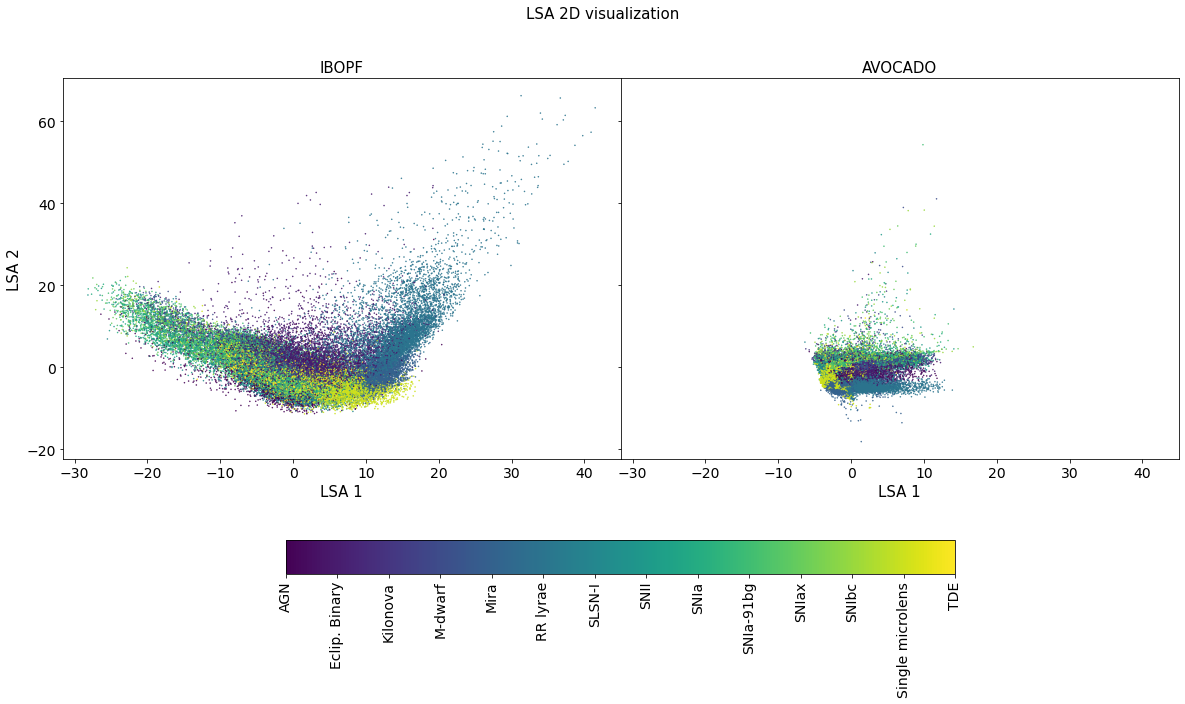

In [40]:
visualize_compare_repr(reducer="LSA")

Loading dataset 'plasticc_augment_v3'...
Loading features...
Loading dataset 'plasticc_augment_v3'...
Loading features...
raw sparse features shape: (80856, 816)
processing  IBOPF
-> DONE (TIME: 134.287)
processing  AVOCADO
-> DONE (TIME: 133.527)
PLOTING...
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


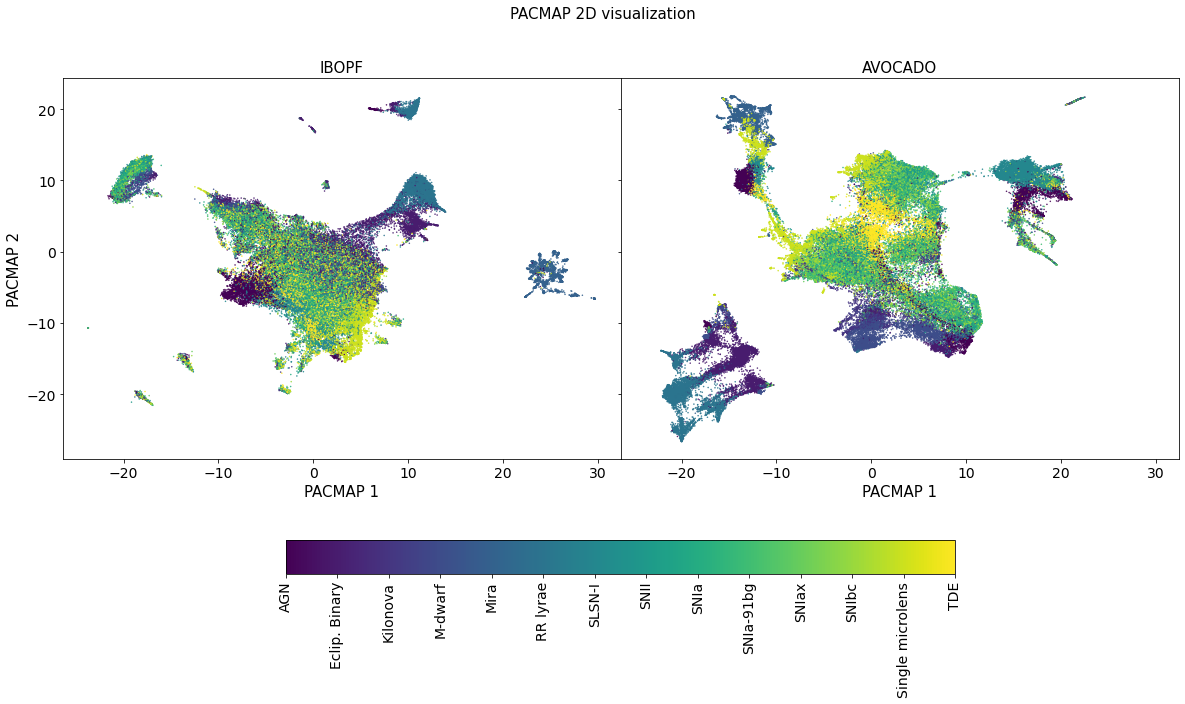

In [5]:
visualize_compare_repr(reducer="PACMAP")

## visualize different parameters for UMAP

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


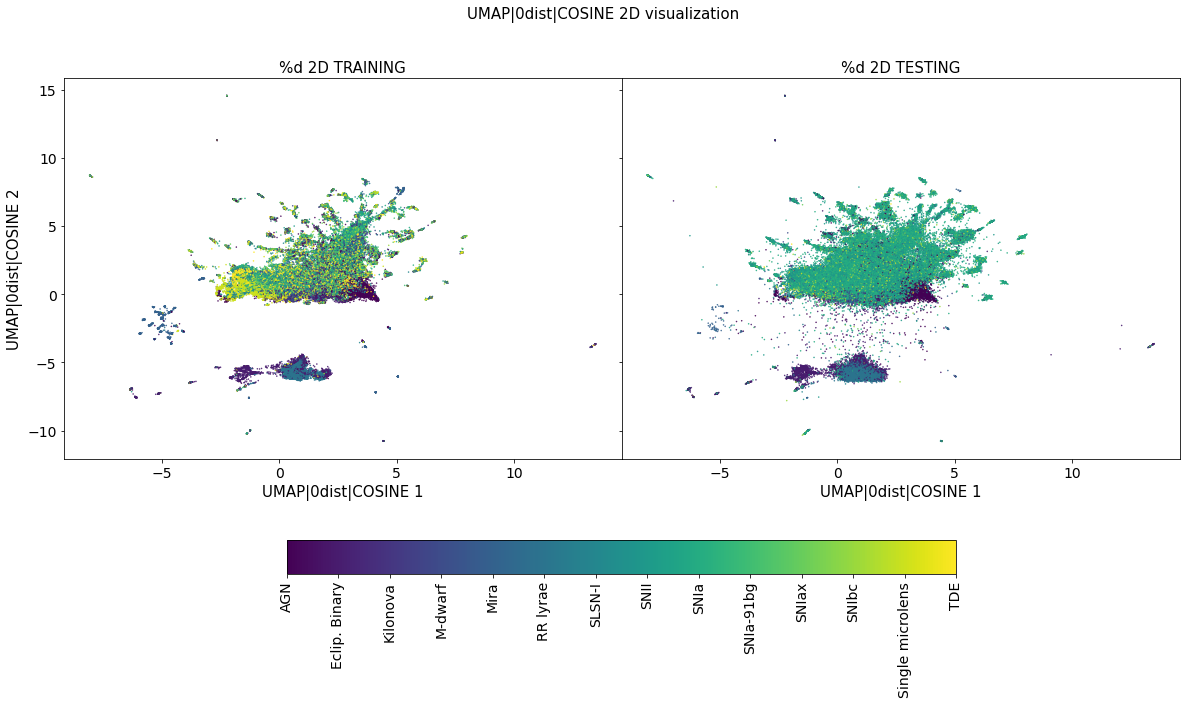

In [3]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_0.000000_cosine_2", reducer_name="UMAP|0dist|COSINE")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


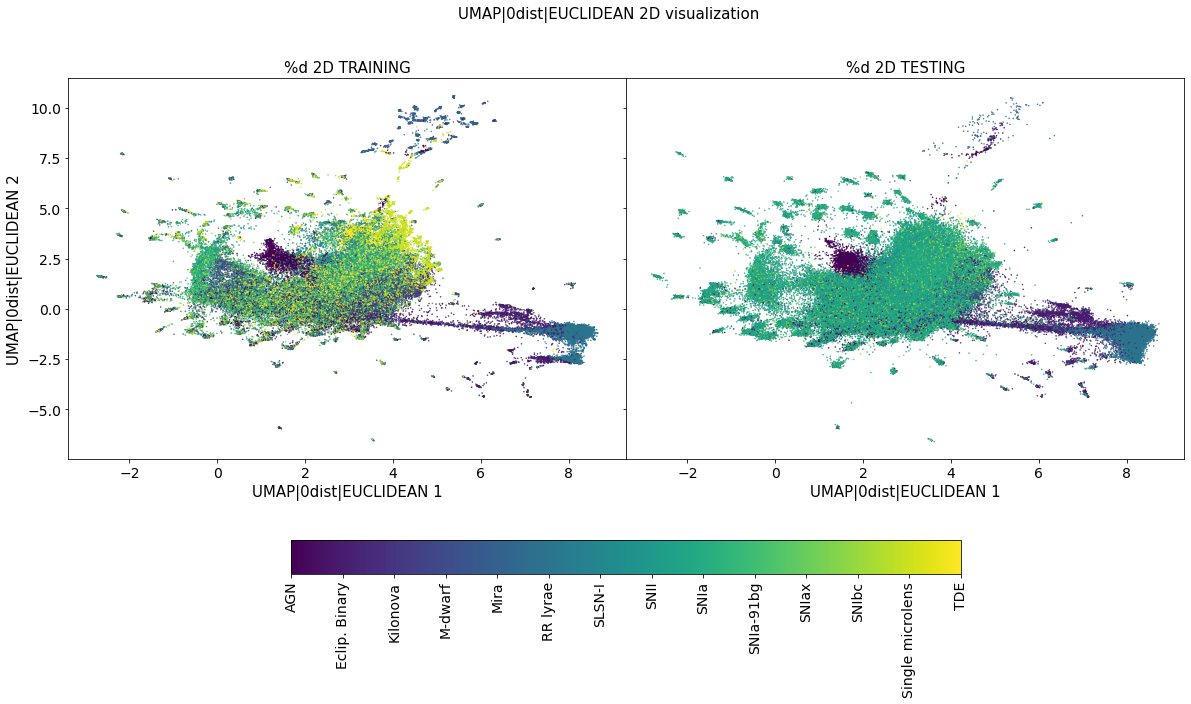

In [4]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_0.000000_euclidean_2", reducer_name="UMAP|0dist|EUCLIDEAN")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
classes dist in test 10%
defaultdict(<class 'int'>, {42: 99949, 67: 4061, 90: 165892, 88: 10294, 52: 6362, 62: 17624, 92: 19426, 15: 1377, 65: 9407, 53: 161, 95: 3556, 16: 9673, 6: 130, 64: 12})
classes dist in test 10%
defaultdict(<class 'int'>, {42: 20000, 67: 4061, 90: 20000, 88: 10294, 52: 6362, 62: 17624, 92: 19426, 15: 1377, 65: 9407, 53: 161, 95: 3556, 16: 9673, 6: 130, 64: 12})
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


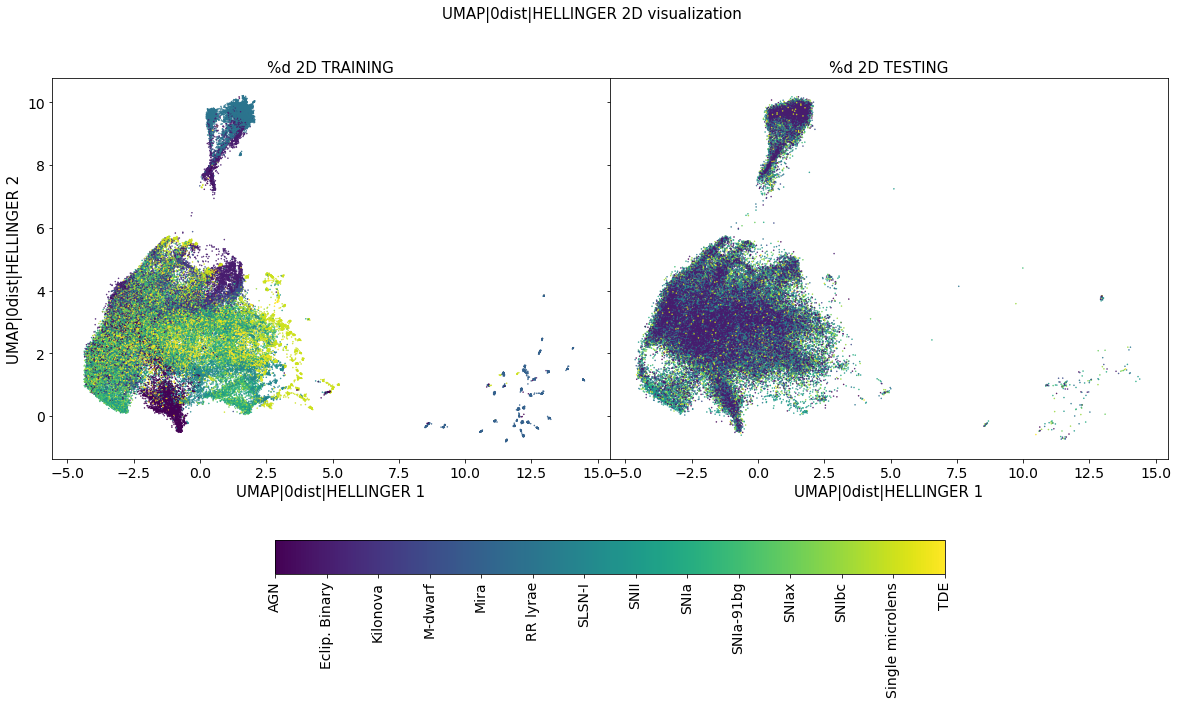

In [26]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_0.000000_hellinger_2", 
                            reducer_name="UMAP", title="UMAP|0dist|HELLINGER")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


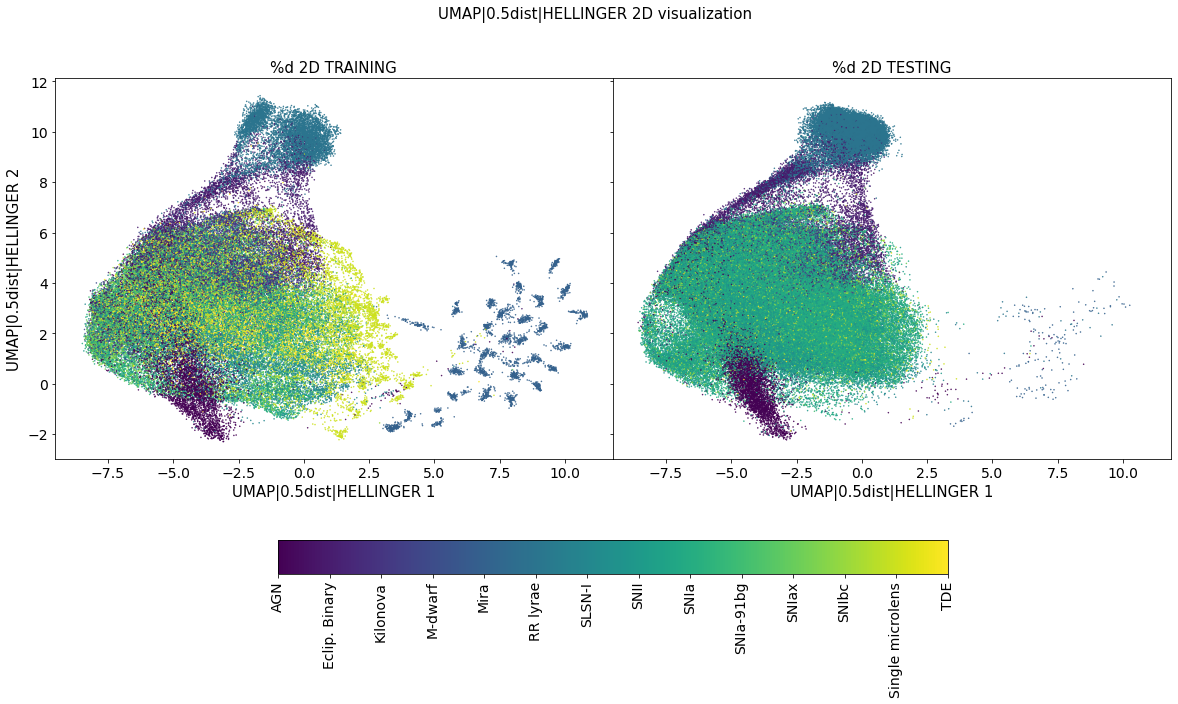

In [8]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_0.500000_hellinger_2", reducer_name="UMAP|0.5dist|HELLINGER")

## Visualize train-test performance

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


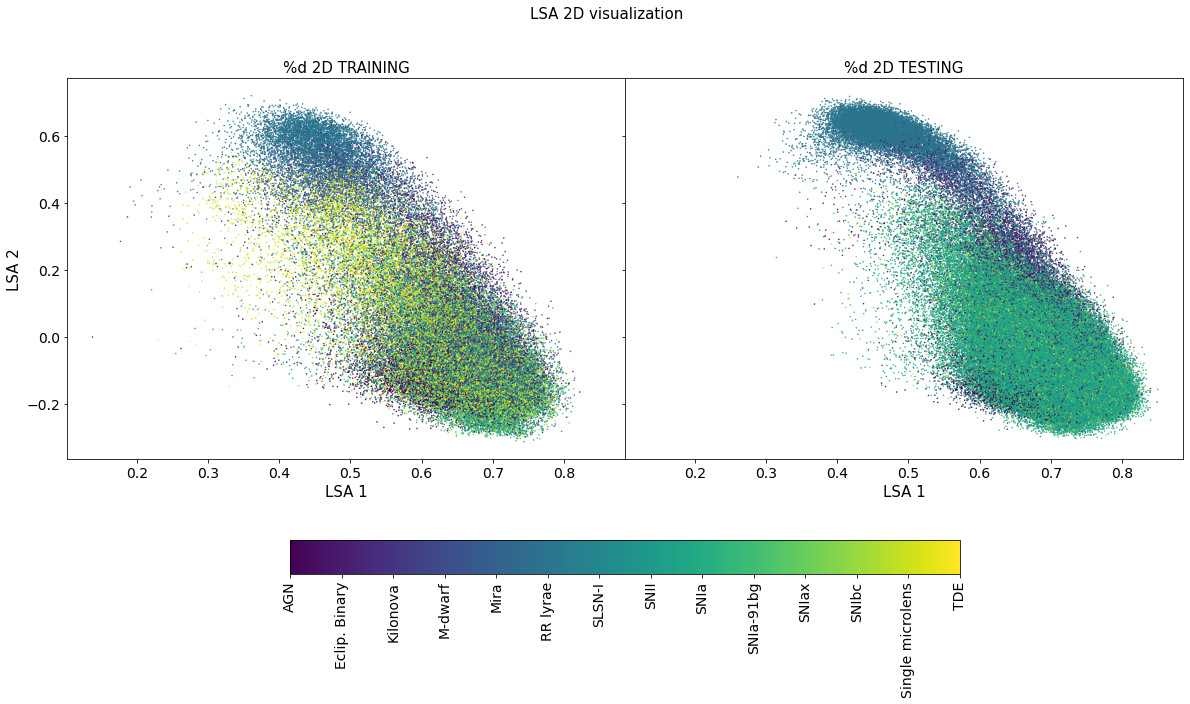

In [7]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_LSA_2", reducer_name="LSA")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


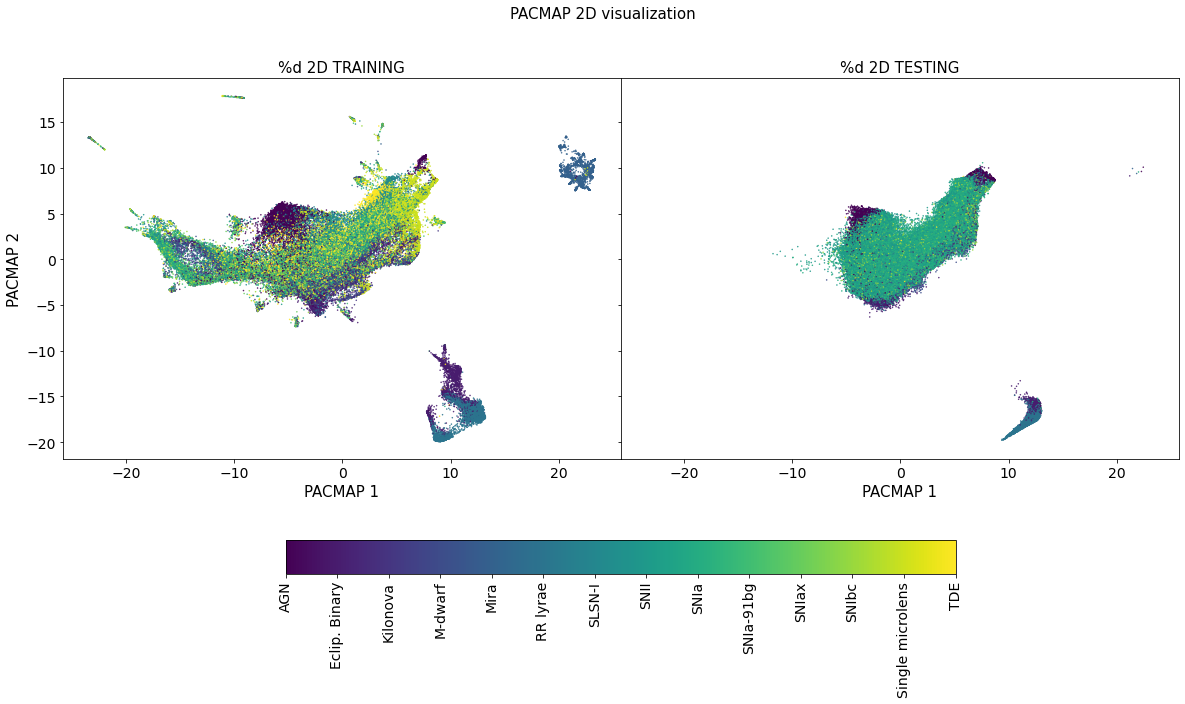

In [8]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_PACMAP_2", reducer_name="PACMAP")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


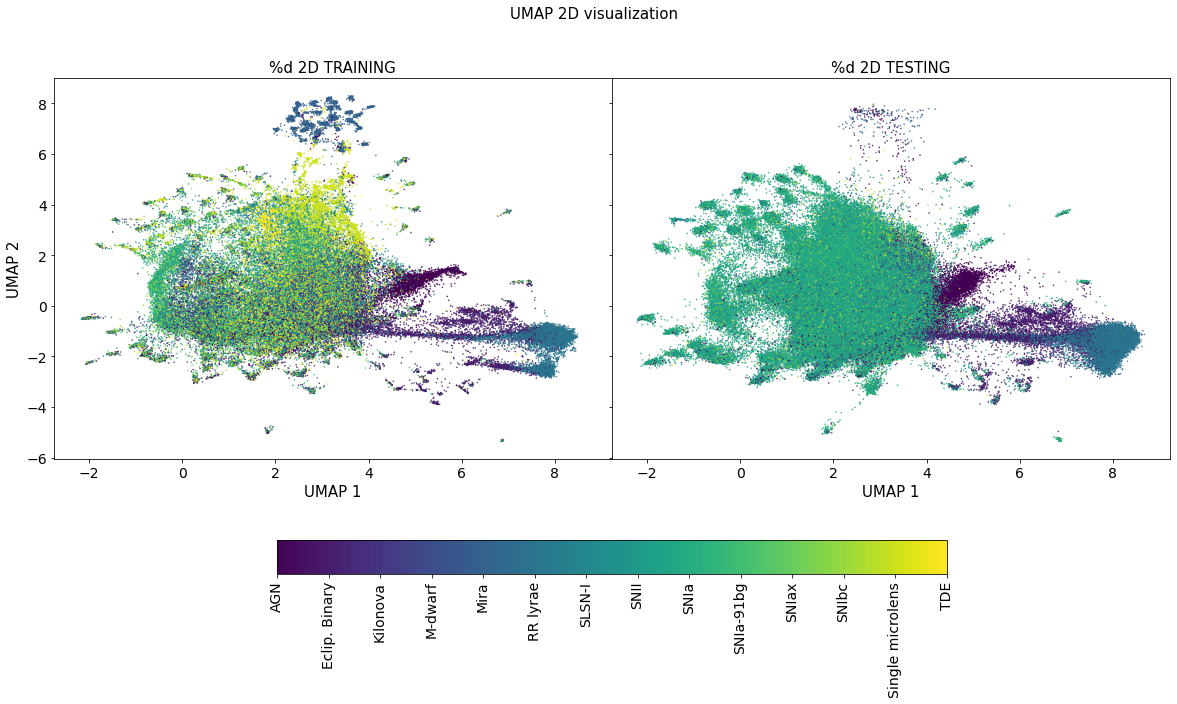

In [9]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_2", reducer_name="UMAP")

Loading dataset 'plasticc_augment_v3'...
Loading features...
raw compact features shape: (80856, 2)
Loading dataset 'plasticc_test'...
Loading features...
raw compact features shape: (349275, 2)
reducing metadata
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']
['AGN' 'Eclip. Binary' 'Kilonova' 'M-dwarf' 'Mira' 'RR lyrae' 'SLSN-I'
 'SNII' 'SNIa' 'SNIa-91bg' 'SNIax' 'SNIbc' 'Single microlens' 'TDE']


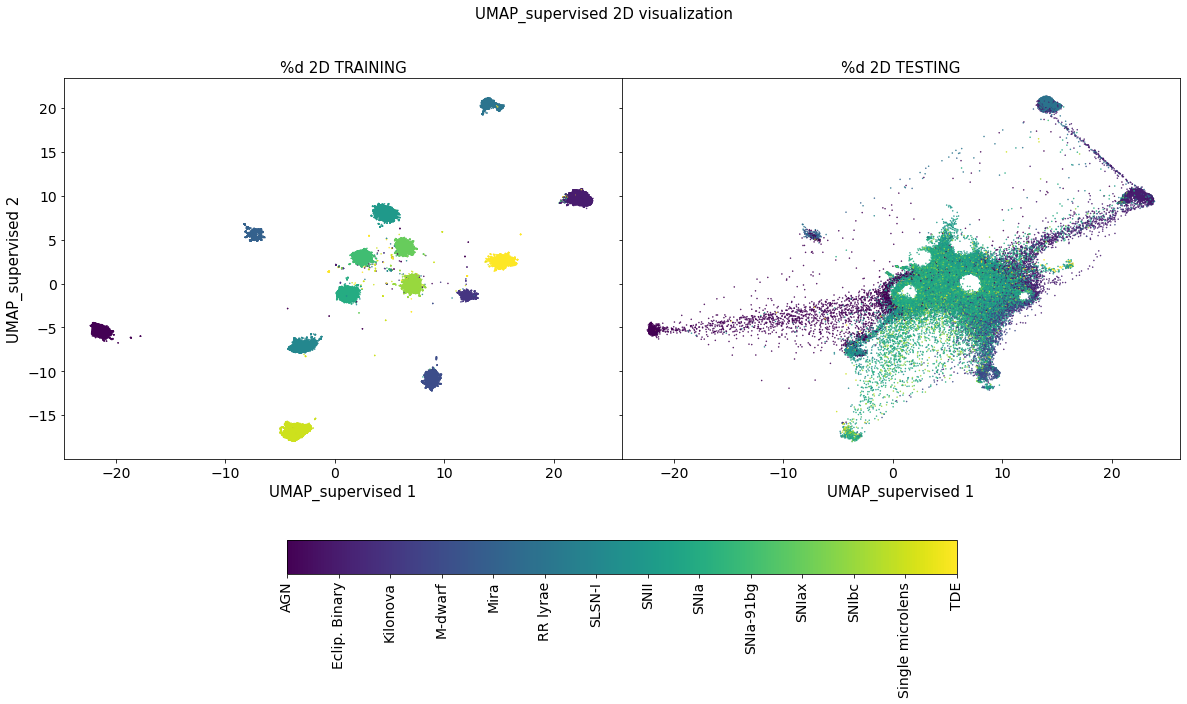

In [10]:
visualize_compare_transform(repr_method="IBOPF", tag="features_v3_UMAP_supervised_2", reducer_name="UMAP_supervised")

# Metrics evaluation
- adjusted mutual-information score
- Adjusted Rand index
- balanced accuracy

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_score, recall_score
import avocado
import itertools

In [4]:
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
}
type_ids = plot_labels_extra_short.keys()
# 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="YlGnBu"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    
def run_for_single_data(test_label, pred_label, title="Conf. matrix", out_file=None):
    classes = np.unique(test_label)
    labels_order = [42, 52, 62, 64, 67, 90, 95, 16, 53, 92, 6, 15, 65, 88]
    labels_keys = [plot_labels_extra_short[x] for x in labels_order]
    conf = confusion_matrix(test_label, pred_label, labels=labels_order)
    acc = balanced_accuracy_score(test_label, pred_label)
    
    fig = plt.figure(figsize=(12, 9))
    plot_confusion_matrix(conf, classes=labels_keys, normalize=True,
                      title='%s (Acc: %.3f)' % (title, acc))
    if out_file is not None:
        plt.savefig(out_file)
        
def load_lgbm(file):
    dataset = Dataset.load("plasticc_test", metadata_only=True)
    pred = avocado.read_dataframe(file, "predictions", chunk=None, num_chunks=None)
    if pred.shape[0] < dataset.metadata.shape[0]:
        metadata = dataset.metadata[dataset.metadata.index.isin(pred.index)]
    else:
        metadata = dataset.metadata
    metadata = metadata[["class"]]
    true_classes = pd.merge(pred, metadata, left_index=True, right_index=True)["class"]
    # true_classes = metadata['class']
    # pred2 = pred.iloc[0,:]
    # print(type(true_classes), type(pred2))
    
    mask = true_classes.isin(pred.columns)
    # print(mask)
    
    mask_classes = true_classes[mask]
    # print(mask_classes)
    mask_pred = pred[mask]

    # mask.index
    classes = pred.columns

    true_indices = np.argmax(pd.get_dummies(mask_classes).values, axis=1)
    true_indices = np.array([classes[x] for x in true_indices])
    pred_indices = np.argmax(mask_pred.values, axis=-1)
    pred_indices = np.array([classes[x] for x in pred_indices])
    return true_indices, pred_indices
    
def data_lgbm(file):
    true_indices, pred_indices = load_lgbm(file)
    
    adj_rand = adjusted_rand_score(true_indices, pred_indices)
    adj_m_info = adjusted_mutual_info_score(true_indices, pred_indices)
    b_acc = balanced_accuracy_score(true_indices, pred_indices)
    
    pscore_macro = precision_score(true_indices, pred_indices, average='macro')
    pscore_micro = precision_score(true_indices, pred_indices, average='micro')
    pscore_w = precision_score(true_indices, pred_indices, average='weighted')
    
    rscore_macro = recall_score(true_indices, pred_indices, average='macro')
    rscore_micro = recall_score(true_indices, pred_indices, average='micro')
    rscore_w = recall_score(true_indices, pred_indices, average='weighted')
    
    print("ADJUSTES RAND SCORE:", adj_rand)
    print("ADJUSTED MUTUAL INFORMATION SCORE:", adj_m_info)
    print("BALANCED ACCURACY:", b_acc)
    print("PRECISION SCORE (micro|macro|weighted): %.2f, %.2f, %.2f" % (pscore_macro, pscore_micro, pscore_w))
    print("RECALL SCORE (micro|macro|weighted): %.2f, %.2f, %.2f" % (rscore_macro, rscore_micro, rscore_w))
    return true_indices, pred_indices
    
def data_knn(file):
    dataset = Dataset.load("plasticc_test", metadata_only=True)
    df = avocado.read_dataframe(file, "predictions", chunk=None, num_chunks=None)
    true_indices = dataset.metadata['class']
    
    pred_indices = df["pred"].to_numpy()
    adj_rand = adjusted_rand_score(true_indices, pred_indices)
    adj_m_info = adjusted_mutual_info_score(true_indices, pred_indices)
    b_acc = balanced_accuracy_score(true_indices, pred_indices)
    print("ADJUSTES RAND SCORE:", adj_rand)
    print("ADJUSTED MUTUAL INFORMATION SCORE:", adj_m_info)
    print("BALANCED ACCURACY:", b_acc)
    return true_indices, pred_indices



## Plt UMAP vs LSA on different number of components

In [5]:
# plot all experimentos
files_lsa = []
n_lsa = []
for n in [2, 5, 10, 20, 30, 50]:
    files_lsa.append("predictions_plasticc_test_lowDimExp_features_v3_LSA_%d.h5" % n)
    n_lsa.append(n)
for n in [70, 100, 130, 160, 200, 250, 300, 361]:
    files_lsa.append("predictions_plasticc_test_highDim_features_v3_LSA_%d.h5" % n)
    n_lsa.append(n)
    
files_umap = []
n_umap = []
for n in [2, 5, 10, 20, 30, 50]:
    files_umap.append("predictions_plasticc_test_lowDimExp_features_v3_UMAP_%d.h5" % n)
    n_umap.append(n)
files_umap.append("predictions_plasticc_test_highDim_features_v3_UMAP_70.h5")
n_umap.append(70)

files_umap_supervised = []
n_umap_supervised = []
for n in [2, 5, 10, 20, 30]:
    files_umap_supervised.append("predictions_plasticc_test_reprSupr_features_v3_UMAP_supervised_%d.h5" % n)
    n_umap_supervised.append(n)
    
files_umap_optimal = []
n_umap_optimal = []
for n in [2, 5, 10, 20, 30, 50]:
    c_name = "umapExp"
    if n in [2, 30]:
        c_name = "baseExp"
    files_umap_optimal.append("predictions_plasticc_test_%s_features_v3_UMAP_0.000000_hellinger_%d.h5" % (c_name, n))
    n_umap_optimal.append(n)

base_path = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/"
lsa_accs = []
for f in files_lsa:
    print(f + ": ", end="")
    y_true, y_pred = load_lgbm(os.path.join(base_path, f))
    acc = balanced_accuracy_score(y_true, y_pred)
    lsa_accs.append(acc)
    print(acc)
    
umap_accs = []
for f in files_umap:
    print(f + ": ", end="")
    y_true, y_pred = load_lgbm(os.path.join(base_path, f))
    acc = balanced_accuracy_score(y_true, y_pred)
    umap_accs.append(acc)
    print(acc)
    
umap_supervised_accs = []
for f in files_umap_supervised:
    print(f + ": ", end="")
    y_true, y_pred = load_lgbm(os.path.join(base_path, f))
    acc = balanced_accuracy_score(y_true, y_pred)
    umap_supervised_accs.append(acc)
    print(acc)
    
umap_optimal_accs = []
for f in files_umap_optimal:
    print(f + ": ", end="")
    y_true, y_pred = load_lgbm(os.path.join(base_path, f))
    acc = balanced_accuracy_score(y_true, y_pred)
    umap_optimal_accs.append(acc)
    print(acc)

predictions_plasticc_test_lowDimExp_features_v3_LSA_2.h5: 0.4214355451738851
predictions_plasticc_test_lowDimExp_features_v3_LSA_5.h5: 0.56185152569231
predictions_plasticc_test_lowDimExp_features_v3_LSA_10.h5: 0.6265191198226265
predictions_plasticc_test_lowDimExp_features_v3_LSA_20.h5: 0.6368316278151207
predictions_plasticc_test_lowDimExp_features_v3_LSA_30.h5: 0.6416726607241302
predictions_plasticc_test_lowDimExp_features_v3_LSA_50.h5: 0.6401262369396564
predictions_plasticc_test_highDim_features_v3_LSA_70.h5: 0.6483888662429104
predictions_plasticc_test_highDim_features_v3_LSA_100.h5: 0.649439544927526
predictions_plasticc_test_highDim_features_v3_LSA_130.h5: 0.644618619554616
predictions_plasticc_test_highDim_features_v3_LSA_160.h5: 0.6559867970273748
predictions_plasticc_test_highDim_features_v3_LSA_200.h5: 0.654843035057611
predictions_plasticc_test_highDim_features_v3_LSA_250.h5: 0.643754441984895
predictions_plasticc_test_highDim_features_v3_LSA_300.h5: 0.6503755564612932
pr

In [6]:
y_true, y_pred = load_lgbm("/media/francisco/data/irregular-bag-of-pattern/data/plasticc/AVOCADO/predictions/predictions_plasticc_test_lgbm.h5")
avocado_acc = balanced_accuracy_score(y_true, y_pred)

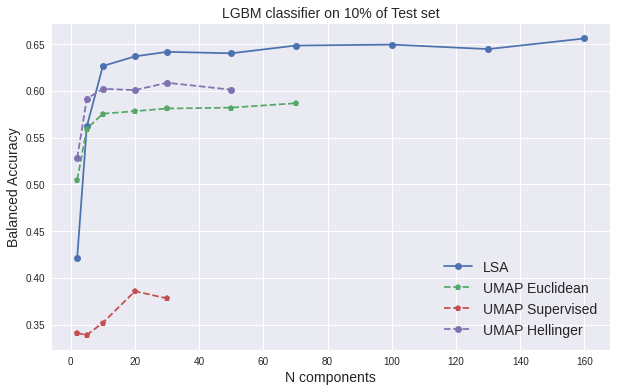

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(n_lsa[:10], lsa_accs[:10], "o-", label="LSA")
plt.plot(n_umap, umap_accs, "p--", label="UMAP Euclidean")
plt.plot(n_umap_supervised, umap_supervised_accs, "p--", label="UMAP Supervised")
plt.plot(n_umap_optimal, umap_optimal_accs, "o--", label="UMAP Hellinger")
# plt.axhline(avocado_acc)
# plt.xscale("log")
plt.xlabel("N components", fontsize=14)
plt.ylabel("Balanced Accuracy", fontsize=14)
plt.title("LGBM classifier on 10% of Test set", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("notebooks/new_figures/compare_method_acc_n_components.png")

## conf matrix exp UMAP

ADJUSTES RAND SCORE: 0.15010459328754955
ADJUSTED MUTUAL INFORMATION SCORE: 0.2737215765638947
BALANCED ACCURACY: 0.49807261344331594
PRECISION SCORE (micro|macro|weighted): 0.32, 0.36, 0.60
RECALL SCORE (micro|macro|weighted): 0.50, 0.36, 0.36
Normalized confusion matrix


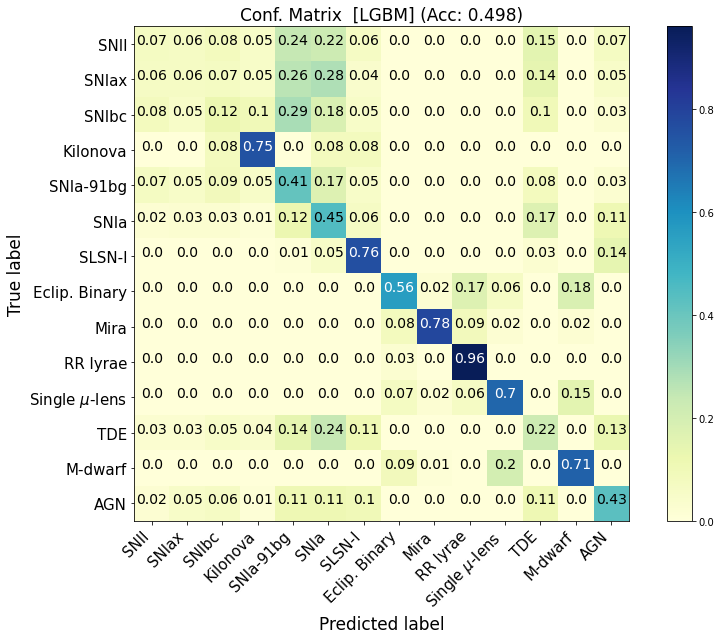

In [4]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_0.000000_cosine_2.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.14361979532267874
ADJUSTED MUTUAL INFORMATION SCORE: 0.28299888371338283
BALANCED ACCURACY: 0.5137203559780797
PRECISION SCORE (micro|macro|weighted): 0.37, 0.33, 0.65
RECALL SCORE (micro|macro|weighted): 0.51, 0.33, 0.33
Normalized confusion matrix


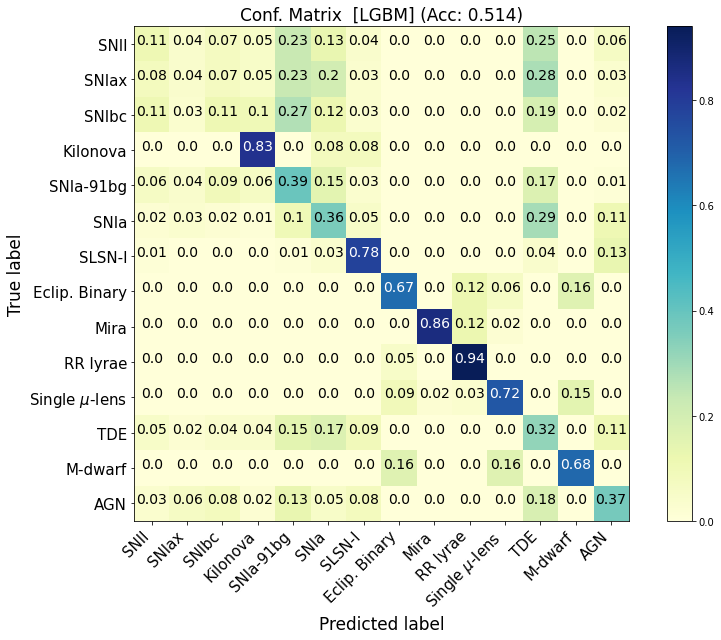

In [5]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_0.000000_euclidean_2.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.16409737826744475
ADJUSTED MUTUAL INFORMATION SCORE: 0.29694861259540645
BALANCED ACCURACY: 0.5279361724495832
PRECISION SCORE (micro|macro|weighted): 0.37, 0.34, 0.67
RECALL SCORE (micro|macro|weighted): 0.53, 0.34, 0.34
Normalized confusion matrix


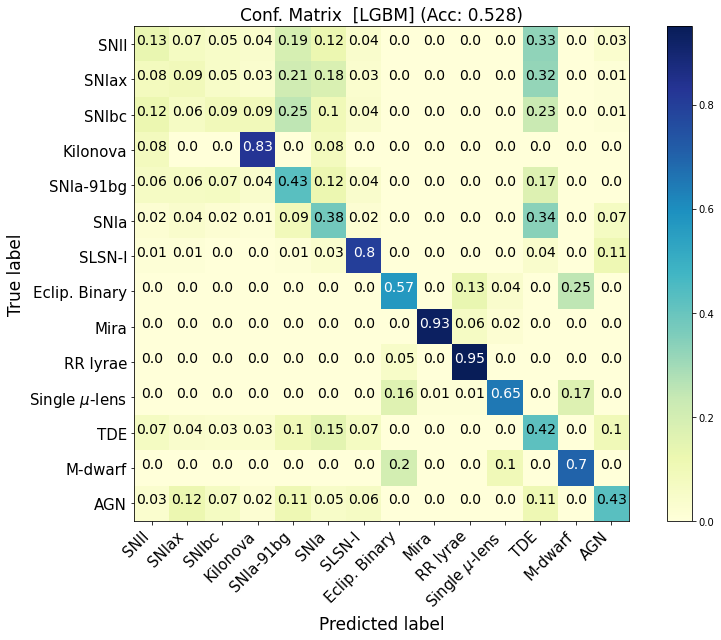

In [6]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_0.000000_hellinger_2.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.16841738955180863
ADJUSTED MUTUAL INFORMATION SCORE: 0.2987207944589189
BALANCED ACCURACY: 0.5111215142966367
PRECISION SCORE (micro|macro|weighted): 0.37, 0.34, 0.68
RECALL SCORE (micro|macro|weighted): 0.51, 0.34, 0.34
Normalized confusion matrix


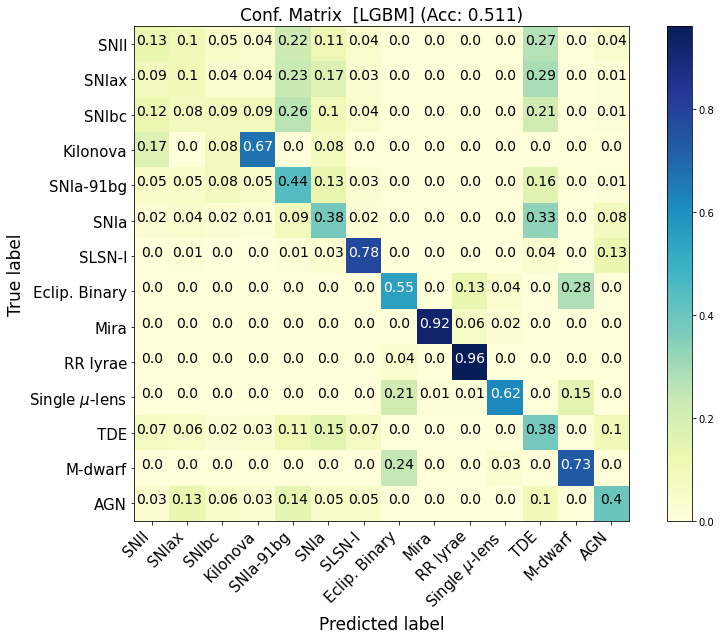

In [4]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_0.500000_hellinger_2.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.2534537944582093
ADJUSTED MUTUAL INFORMATION SCORE: 0.33951910490474524
BALANCED ACCURACY: 0.6086312974277159
PRECISION SCORE (micro|macro|weighted): 0.40, 0.43, 0.71
RECALL SCORE (micro|macro|weighted): 0.61, 0.43, 0.43
Normalized confusion matrix


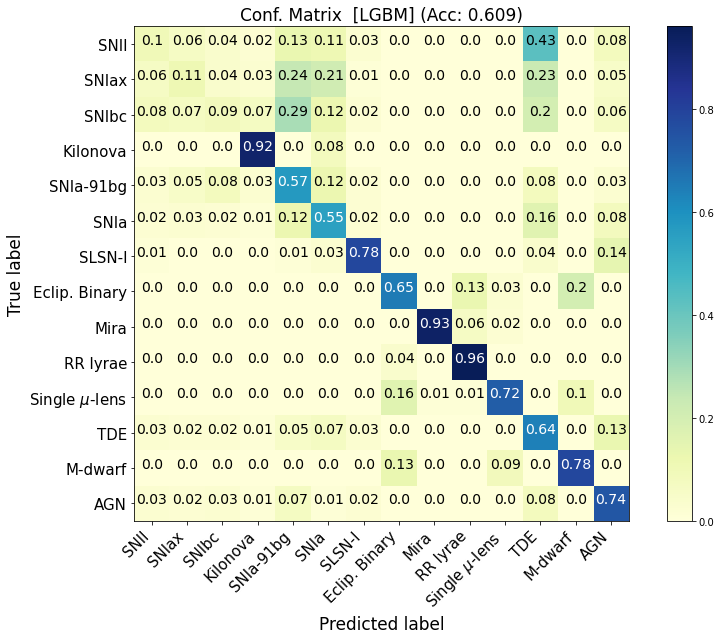

In [4]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_0.000000_hellinger_30.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.07848457250503259
ADJUSTED MUTUAL INFORMATION SCORE: 0.21685117306833782
BALANCED ACCURACY: 0.40007378482799105
PRECISION SCORE (micro|macro|weighted): 0.35, 0.26, 0.66
RECALL SCORE (micro|macro|weighted): 0.40, 0.26, 0.26
Normalized confusion matrix


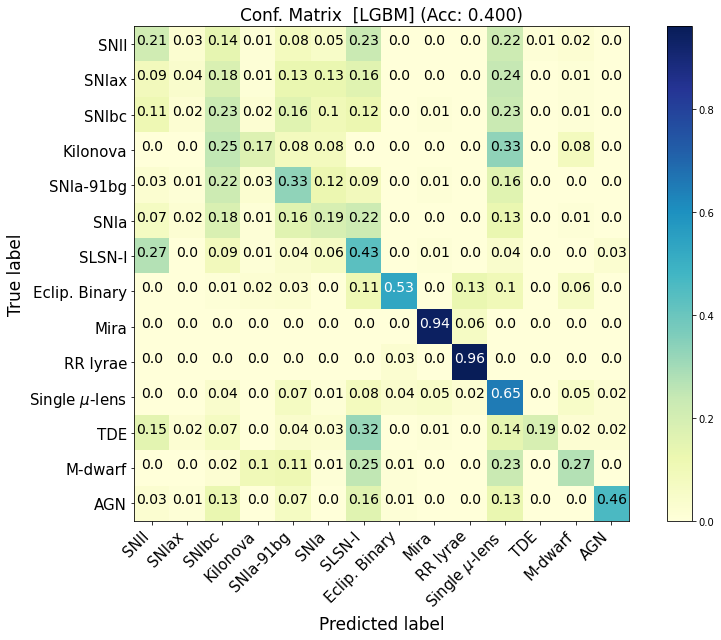

In [6]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_baseExp_features_v3_UMAP_supervised_0.000000_hellinger_30.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

## Classification matrix on best n_component of each one

In [ ]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_highDim_features_v3_UMAP_70.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

ADJUSTES RAND SCORE: 0.35267937813608746
ADJUSTED MUTUAL INFORMATION SCORE: 0.38216890687875227
BALANCED ACCURACY: 0.6556919629660501
PRECISION SCORE (micro|macro|weighted): 0.44, 0.57, 0.72
RECALL SCORE (micro|macro|weighted): 0.66, 0.57, 0.57
Normalized confusion matrix


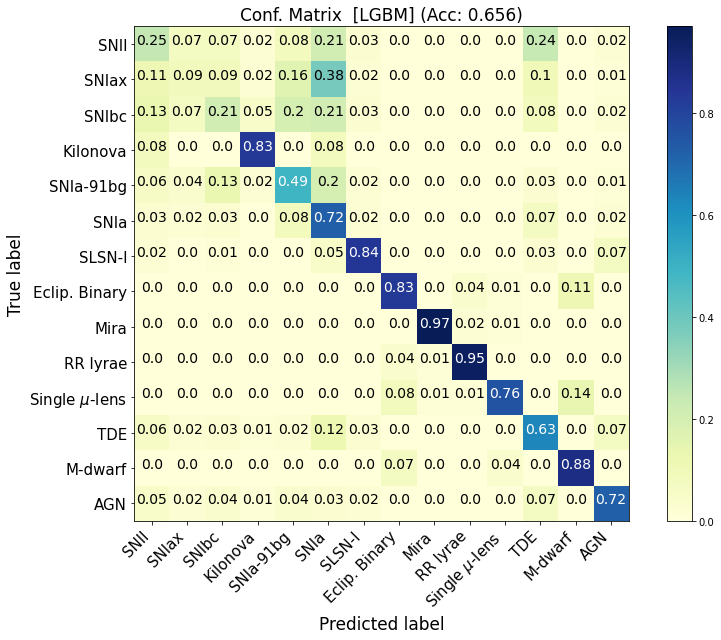

In [39]:
file = "/media/francisco/data/irregular-bag-of-pattern/data/plasticc/IBOPF/predictions/predictions_plasticc_test_highDim_features_v3_LSA_361.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix  [LGBM]")

# Classification on full test set

ADJUSTES RAND SCORE: 0.5672096324006151
ADJUSTED MUTUAL INFORMATION SCORE: 0.5512576074928959
BALANCED ACCURACY: 0.8186523211314695
PRECISION SCORE (micro|macro|weighted): 0.59, 0.75, 0.85
RECALL SCORE (micro|macro|weighted): 0.82, 0.75, 0.75
Normalized confusion matrix


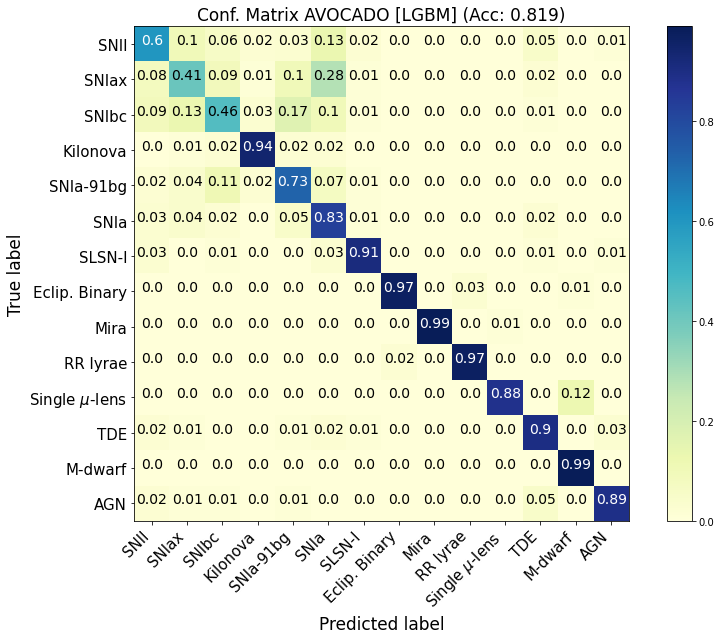

In [32]:
file = "D:/tesis/data/plasticc/AVOCADO/predictions/predictions_plasticc_test_flat_weight.h5"
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix AVOCADO [LGBM]", out_file="notebooks/new_figures/cm_avocado_lgbm.png")

<> IBOPF-LSA <>
ADJUSTES RAND SCORE: 0.35462380732748855
ADJUSTED MUTUAL INFORMATION SCORE: 0.383333961069093
BALANCED ACCURACY: 0.650579771335526
PRECISION SCORE (micro|macro|weighted): 0.44, 0.57, 0.73
RECALL SCORE (micro|macro|weighted): 0.65, 0.57, 0.57
Normalized confusion matrix


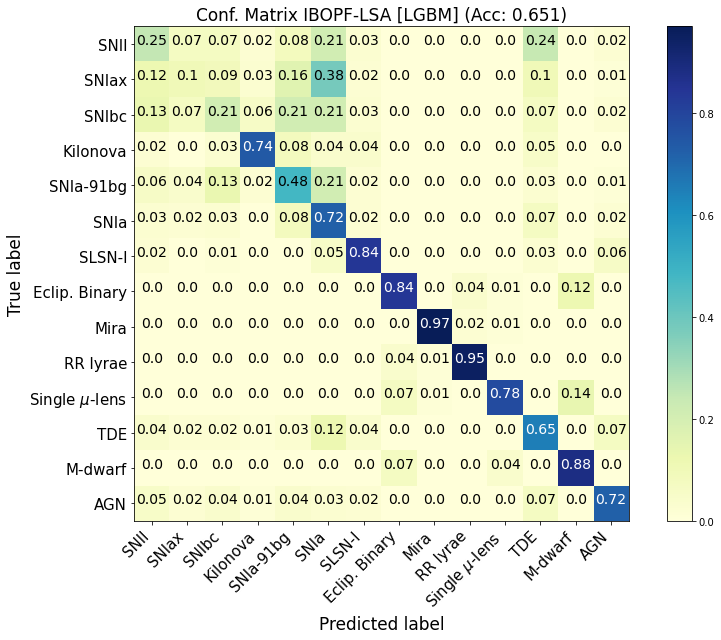

In [33]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_flat_weight_features_v3_LSA.h5"
print("<> IBOPF-LSA <>")
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-LSA [LGBM]", out_file="notebooks/new_figures/cm_ibopf_lsa_lgbm.png")

<> IBOPF-MANOVA <>
ADJUSTES RAND SCORE: 0.38207416274624856
ADJUSTED MUTUAL INFORMATION SCORE: 0.39448171418225836
BALANCED ACCURACY: 0.6451243784023062
PRECISION SCORE (micro|macro|weighted): 0.44, 0.60, 0.72
RECALL SCORE (micro|macro|weighted): 0.65, 0.60, 0.60
Normalized confusion matrix


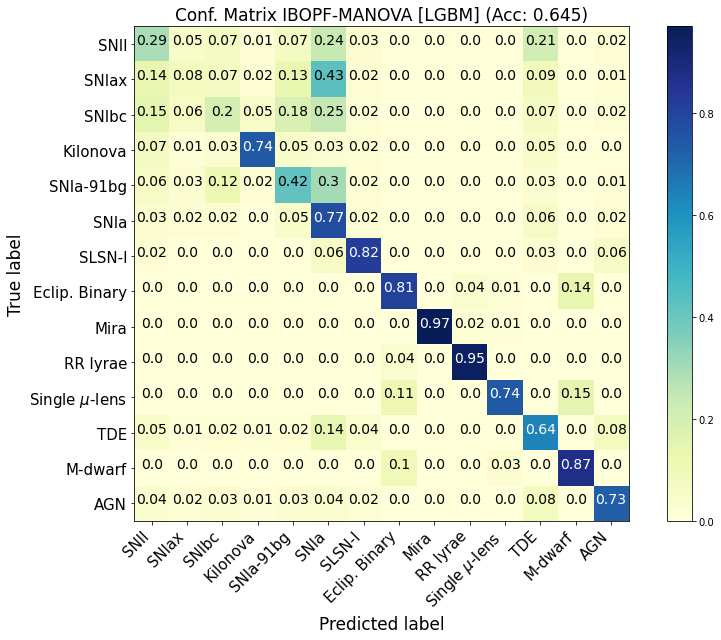

In [35]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_flat_weight_features_v3_MANOVA.h5"
print("<> IBOPF-MANOVA <>")
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-MANOVA [LGBM]", out_file="notebooks/new_figures/cm_ibopf_manova_lgbm.png")

<> IBOPF-LSA KNN <>
ADJUSTES RAND SCORE: 0.05665679679038772
ADJUSTED MUTUAL INFORMATION SCORE: 0.1531613699421573
BALANCED ACCURACY: 0.2956701532051355
Normalized confusion matrix


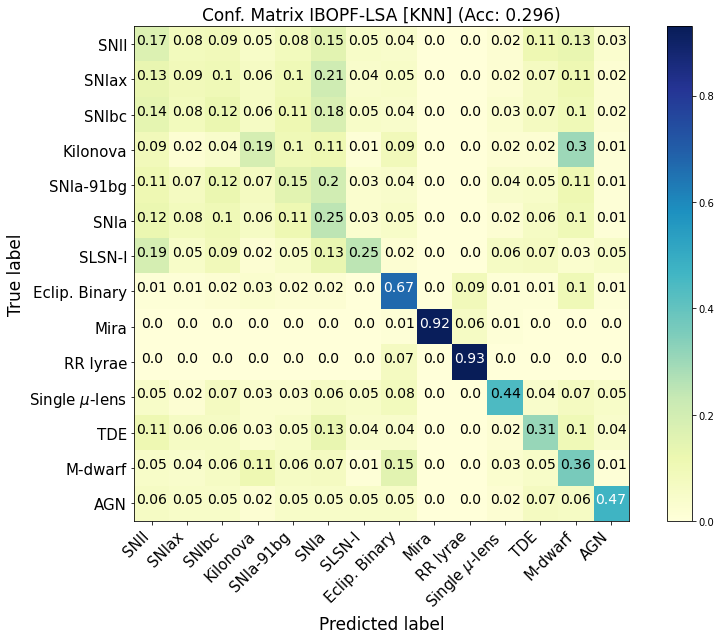

In [36]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN_features_v3_LSA.h5"
print("<> IBOPF-LSA KNN <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-LSA [KNN]", out_file="notebooks/new_figures/cm_lsa_knn.png")

<> AVOCADO KNN <>
ADJUSTES RAND SCORE: 0.07652057482039389
ADJUSTED MUTUAL INFORMATION SCORE: 0.21283310798896382
BALANCED ACCURACY: 0.3448946523324483
Normalized confusion matrix


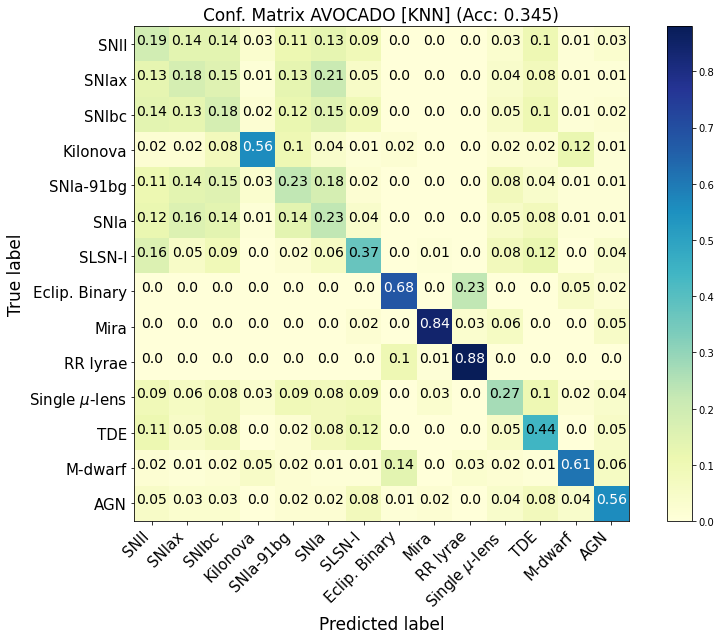

In [37]:
file = "D:/tesis/data/plasticc/AVOCADO/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN.h5"
print("<> AVOCADO KNN <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix AVOCADO [KNN]", out_file="notebooks/new_figures/cm_avocado_knn.png")

<> IBOPF-MANOVA KNN <>
ADJUSTES RAND SCORE: 0.06494333150808485
ADJUSTED MUTUAL INFORMATION SCORE: 0.15520536173754396
BALANCED ACCURACY: 0.28558294894591396
Normalized confusion matrix


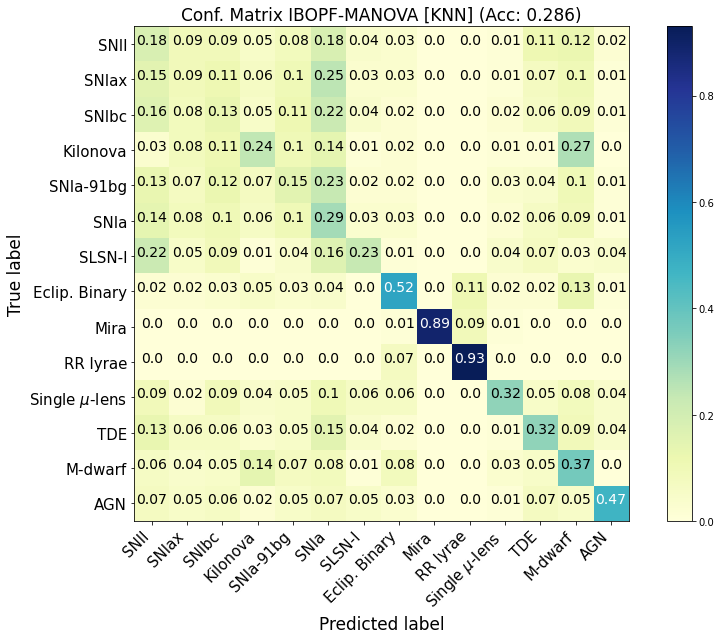

In [38]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN_features_v3_MANOVA.h5"
print("<> IBOPF-MANOVA KNN <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-MANOVA [KNN]", out_file="notebooks/new_figures/cm_manova_knn.png")

<> IBOPF-LSA KNN PROTOTYPE <>
ADJUSTES RAND SCORE: 0.07165531162269062
ADJUSTED MUTUAL INFORMATION SCORE: 0.1974854961229279
BALANCED ACCURACY: 0.33351064985396456
Normalized confusion matrix


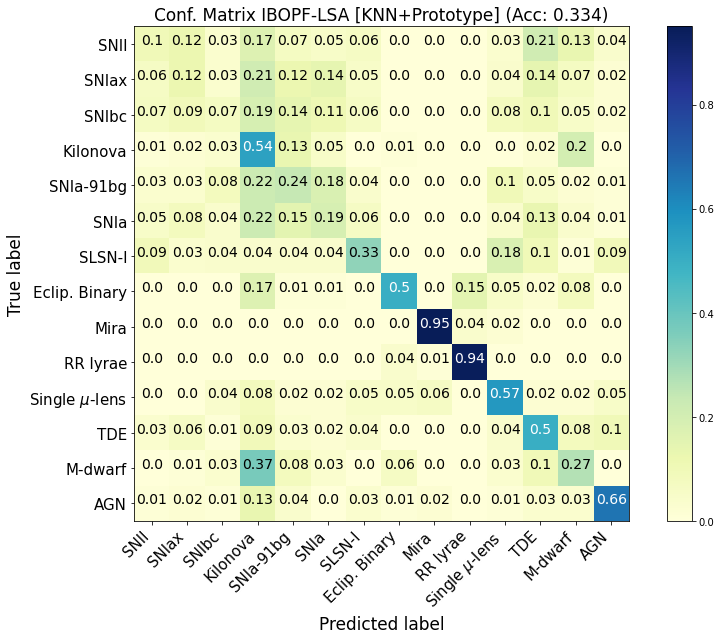

In [39]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN_features_v3_LSA_prototype.h5"
print("<> IBOPF-LSA KNN PROTOTYPE <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-LSA [KNN+Prototype]", out_file="notebooks/new_figures/cm_lsa_knn_prototype.png")

<> IBOPF-MANOVA KNN PROTOTYPE <>
ADJUSTES RAND SCORE: 0.06770377493781718
ADJUSTED MUTUAL INFORMATION SCORE: 0.19121127523579673
BALANCED ACCURACY: 0.3273941146426292
Normalized confusion matrix


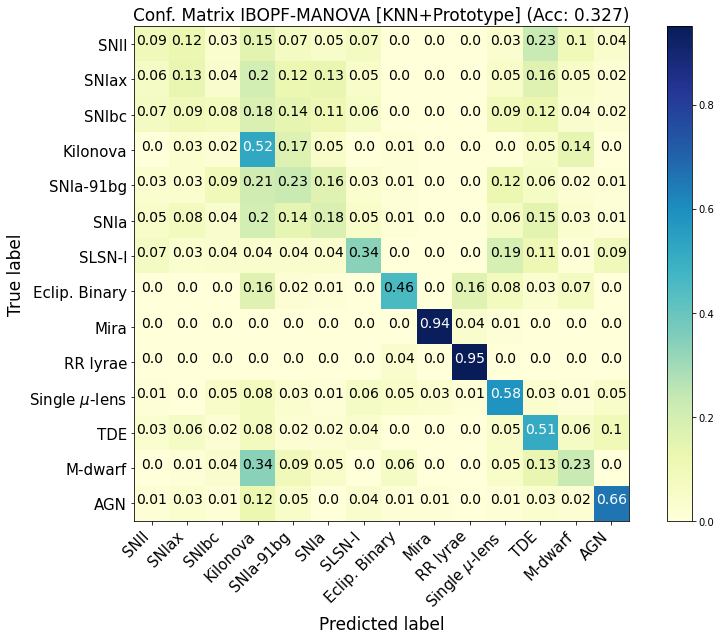

In [40]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN_features_v3_MANOVA_prototype.h5"
print("<> IBOPF-MANOVA KNN PROTOTYPE <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix IBOPF-MANOVA [KNN+Prototype]", out_file="notebooks/new_figures/cm_manova_knn_prototype.png")

<> AVOCADO KNN PROTOTYPE <>
ADJUSTES RAND SCORE: 0.13795779801750038
ADJUSTED MUTUAL INFORMATION SCORE: 0.24486109300314032
BALANCED ACCURACY: 0.2679682344337657
Normalized confusion matrix


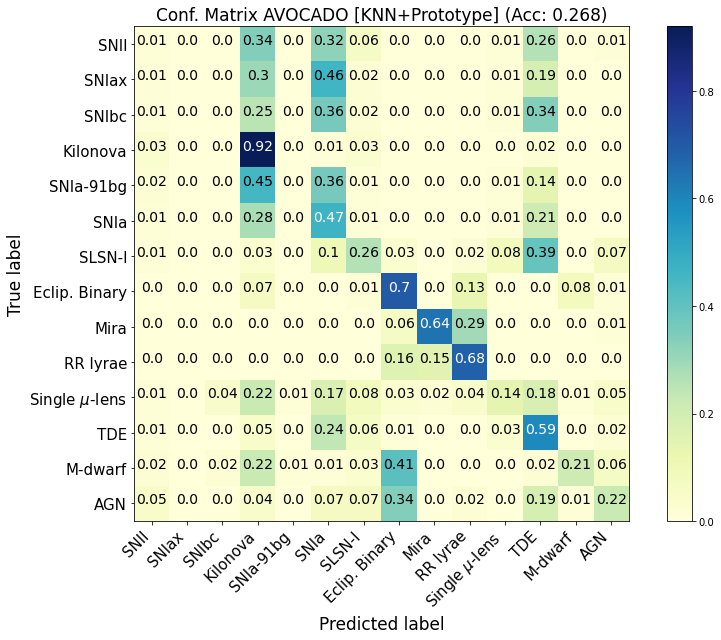

In [41]:
file = "D:/tesis/data/plasticc/AVOCADO/predictions/predictions_plasticc_test_plasticc_augment_v3_K-NN_prototype.h5"
print("<> AVOCADO KNN PROTOTYPE <>")
y_true, y_pred = data_knn(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix AVOCADO [KNN+Prototype]", out_file="notebooks/new_figures/cm_avocado_knn_prototype.png")

<> COMBINED IBOPF-MANOVA + AVOCADO <>
ADJUSTES RAND SCORE: 0.5858467391415386
ADJUSTED MUTUAL INFORMATION SCORE: 0.5598968696311493
BALANCED ACCURACY: 0.8095480257884377
PRECISION SCORE (micro|macro|weighted): 0.60, 0.77, 0.84
RECALL SCORE (micro|macro|weighted): 0.81, 0.77, 0.77
Normalized confusion matrix


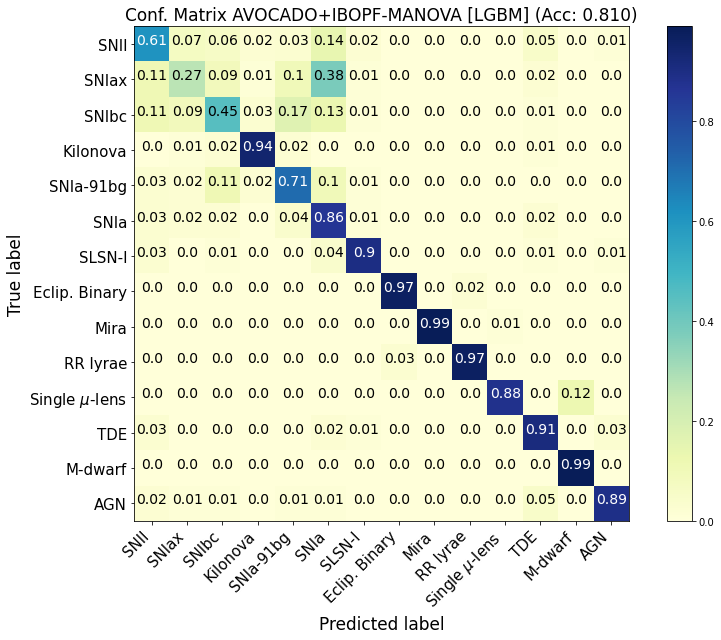

In [42]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_combined_methods_v4_features_v3_MANOVA.h5"
print("<> COMBINED IBOPF-MANOVA + AVOCADO <>")
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix AVOCADO+IBOPF-MANOVA [LGBM]", out_file="notebooks/new_figures/cm_combined_manova_lgbm.png")

<> COMBINED IBOPF-LSA + AVOCADO <>
ADJUSTES RAND SCORE: 0.5673790921488514
ADJUSTED MUTUAL INFORMATION SCORE: 0.5486635517200875
BALANCED ACCURACY: 0.8119072074933262
PRECISION SCORE (micro|macro|weighted): 0.59, 0.75, 0.84
RECALL SCORE (micro|macro|weighted): 0.81, 0.75, 0.75
Normalized confusion matrix


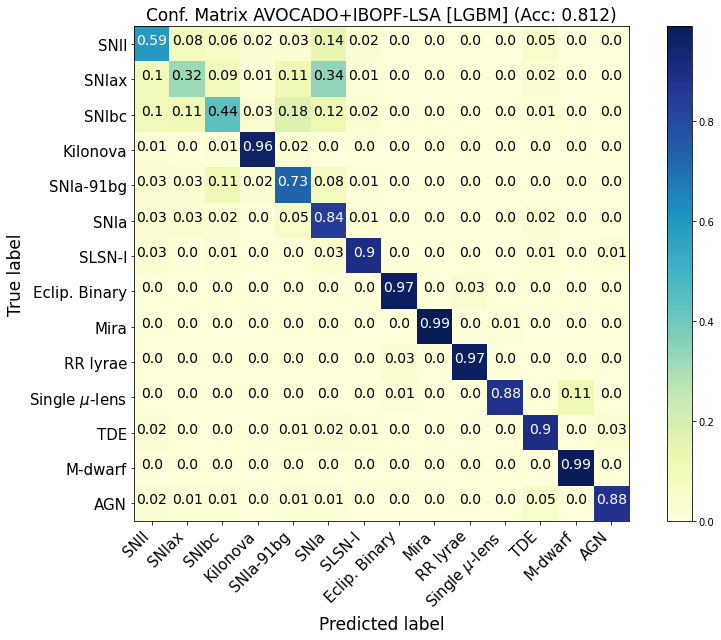

In [43]:
file = "D:/tesis/data/plasticc/IBOPF/predictions/predictions_plasticc_test_combined_methods_v4_features_v3_LSA.h5"
print("<> COMBINED IBOPF-LSA + AVOCADO <>")
y_true, y_pred = data_lgbm(file)
run_for_single_data(y_true, y_pred, title="Conf. Matrix AVOCADO+IBOPF-LSA [LGBM]", out_file="notebooks/new_figures/cm_combined_lsa_lgbm.png")

In [ ]:
import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("./resolution_search.ipynb"), '..'))
print(main_path)
sys.path.insert(0, main_path)
from src.preprocesing import get_mmbopf_plasticc_path, rearrange_splits, gen_dataset_from_h5
from src.mmmbopf.method import IBOPF
from src.mmmbopf.models import CompactIBOPF
from src.feature_selection.analysis_of_variance import manova_rank_fast
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt
import json

data_path = get_mmbopf_plasticc_path()
print(data_path)
resolution_search_main_directory = os.path.join(data_path, "resolution_search")
print(resolution_search_main_directory)
import joblib
import avocado
from statsmodels.multivariate.manova import MANOVA
plt.style.use('seaborn')
%matplotlib inline

D:\tesis
../data/plasticc/IBOPF
../data/plasticc/IBOPF\resolution_search


In [ ]:
filepath = "D:/tesis/data/plasticc/IBOPF/models/features_v3_zero_variance_model.pkl"
pipeline = joblib.load(filepath)

In [ ]:
features = avocado.read_dataframe(
    "D:/tesis/data/plasticc/IBOPF/sparse_features/features_v3_LSA_plasticc_augment_v3.h5",
    "features",
)
print(features.shape)
features2 = pipeline.transform(features)
print(features2.shape)

(80856, 816)
(80856, 768)


In [ ]:
sparse_features = sparse.csr_matrix(features.values)

In [ ]:
metadata = avocado.load("plasticc_augment_v3", metadata_only=True)
labels = metadata.metadata["class"].to_numpy()

In [6]:
%%time
method = IBOPF()
method.config_from_json("D:/tesis/data/plasticc/IBOPF/optimal_config_lsa.json")
method.print_config()

CONFIG FOR GENERAL IBOPF:
>> ALPHA:  4
>> STATISTICAL QUANTITIES:  (TrMm-MmMn-MmMx-TrMn)
>> LEVELS OF RESOLUTION:  [[110.428, 1], [406.482, 1]]
Wall time: 997 µs


In [16]:
%%time
method.C = "LSA"
model_lsa = CompactIBOPF(method="LSA")
model_lsa.set_pipeline(method, 6, 768, None)
model_lsa.pipeline.named_steps["lsa"].sc = 816
model_lsa.fit(sparse_features)
lsa_features = model_lsa.transform(sparse_features)

In [7]:
%%time
method.C = "MANOVA"
model_manova = CompactIBOPF(method="MANOVA")
model_manova.set_pipeline(method, 6, 816//6, None)
model_manova.pipeline.named_steps["manova"].k = 816//6
model_manova.fit(sparse_features, y=labels)
manova_features = model_manova.transform(sparse_features)
manova_features = manova_features.toarray()

C:\ProgramData\Miniconda3\envs\py37\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'parameters' of function 'feature_grouping_fast'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\src\feature_selection\analysis_of_variance.py", line 10:
@jit(nopython=True)
def feature_grouping_fast(X, n_features, n_variables, parameters):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


8/136 features failed because of absence of dependent variables
Wall time: 6.69 s


In [8]:
def k_top_mask(scores, k, parameters, n_variables):
    mask = np.zeros(scores.shape, dtype=bool)
    mask[np.argsort(scores, kind="mergesort")[-k:]] = 1
    
    bop_sizes = []
    for param in parameters:
        (win, wl, q, alpha, q_symbol, tol, mean_bp, num_reduction, threshold) = param
        bop_size = (np.array(alpha).prod() + 1) ** wl
        bop_sizes.append(bop_size)
            
    mask_extended = np.zeros(mask.shape[0] * n_variables, dtype=bool)

    k = 0
    for bsize in bop_sizes:
        for i in range(bsize):
            mask_val = mask[k + i]
            for j in range(n_variables):
                mask_extended[k * n_variables + bsize * j + i] = mask_val
        k += bsize

    return mask_extended

def cum_explained_variance_manova(X, scores, parameters, n_variables, normalize=True):
    cum_exp_var = [0]
    var_full = np.var(X, axis=0).sum()
    for k in range(1, len(scores)):
        mask = k_top_mask(scores, k, parameters, n_variables)
        reduced = X[:, mask]
        cum_exp_var_k = np.var(reduced, axis=0).sum() / var_full
        cum_exp_var.append(cum_exp_var_k)
        
    if normalize:
        cum_exp_var = (cum_exp_var - np.min(cum_exp_var))/(np.max(cum_exp_var)-np.min(cum_exp_var))
        
    return cum_exp_var
    
    

In [9]:
scores = model_manova.pipeline.named_steps["manova"].scores_


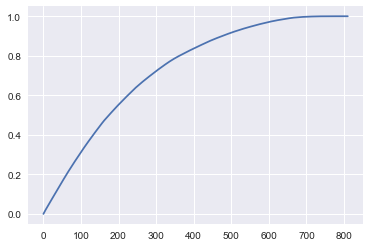

In [15]:
x0 = np.cumsum(np.sort(scores)[::-1])
x0 = (x0 - np.min(x0))/(np.max(x0) - np.min(x0))
plt.plot(np.arange(len(scores)) * 6, x0, label="MANOVA wilks lambda")

In [19]:
x1 = cum_explained_variance_manova(manova_features, scores, method.get_parameters(), 6)

In [17]:
def cum_explained_variance(full_fea, transformed_fea, normalize=True):
    explained_variances = np.var(transformed_fea, axis=0) / np.var(full_fea, axis=0).sum()
    cum_explained_variances = np.cumsum(explained_variances)
    if normalize:
        cum_explained_variances = (cum_explained_variances - np.min(cum_explained_variances)) / (np.max(cum_explained_variances) - np.min(cum_explained_variances))
    return cum_explained_variances

x2 = cum_explained_variance(manova_features, lsa_features)

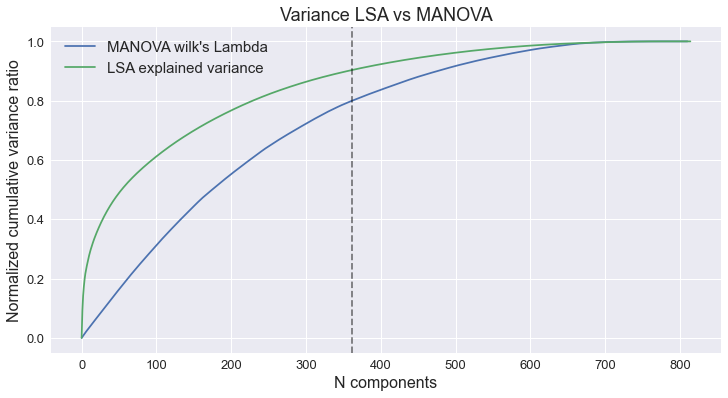

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(scores)) * 6, x0, label="MANOVA wilk's Lambda")
plt.plot(x2, label="LSA explained variance")
plt.axvline(361, color='k', linestyle="--", alpha=0.5)
# plt.plot(x3, label="LSA + DROP_ZERO_VAR")
plt.xlabel("N components", fontsize=16)
plt.ylabel("Normalized cumulative variance ratio", fontsize=16)
plt.title("Variance LSA vs MANOVA", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.savefig("figs/explained_variance.png", dpi=300)